In [94]:
import requests
import json
import pandas as pd
from pprint import pprint
from census import Census
from us import states
import gmaps
import quandl
from config import api_key_housing


#Census API Key
from config import api_key
c = Census(api_key, year=2017)
c2= Census(api_key, year=2011)

# Gmaps
from config import gkey
import gmaps.geojson_geometries
gmaps.configure(api_key=gkey)

# Matplotlib colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import viridis
from matplotlib.cm import coolwarm
from matplotlib.colors import to_hex


In [95]:
# Build DataFrame with states as well as starter columns
state = ["Alabama", "Alaska", "Arizona","Arkansas","California","Colorado","Connecticut","Delaware","District of Columbia","Florida","Georgia",
          "Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts",
          "Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey",
          "New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
          "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin",
          "Wyoming"
]

df = pd.DataFrame(data={"State": state})
df["Home Value '11"] = ""
df["Home Value '17"] = ""
    
df.head()


,State,Home Value '11,Home Value '17
0,Alabama,,
1,Alaska,,
2,Arizona,,
3,Arkansas,,
4,California,,


In [96]:
# Merge in State Code from CSV.
statesdf = pd.read_csv("StateList.csv")
merge_table = pd.merge(df, statesdf, on="State", how="right")
organized_df = merge_table[["State","Area Code", "Home Value '11", "Home Value '17"]]

organized_df.head()



,State,Area Code,Home Value '11,Home Value '17
0,Alabama,3,,
1,Alaska,2,,
2,Arizona,5,,
3,Arkansas,4,,
4,California,6,,


In [97]:
# Extract home values from Quandl API and place in DataFrame 
for index, row in organized_df.iterrows():
    area_code = row["Area Code"]
    area_category = "S"
    indicator_code = "MVALFAH"
    frequency = "annual"
    numberofrows = "11"
    base_url = f"https://www.quandl.com/api/v3/datasets/ZILLOW/{area_category}{area_code}_{indicator_code}?&collapse={frequency}&rows={numberofrows}&api_key={api_key_housing}"
    response1 = requests.get(base_url)
    response1json = response1.json()
    organized_df.loc[index, "Home Value '11"] = response1json['dataset']['data'][8][1]
    organized_df.loc[index, "Home Value '17"] = response1json['dataset']['data'][2][1]


organized_df.head()


,State,Area Code,Home Value '11,Home Value '17
0,Alabama,3,56,69
1,Alaska,2,170,186
2,Arizona,5,79,138
3,Arkansas,4,60,74
4,California,6,196,339


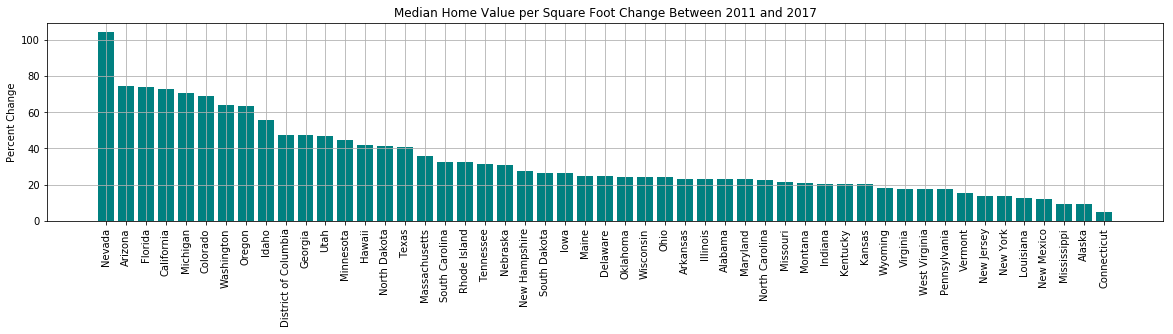

In [98]:
# Change API return to numeric
organized_df[["Home Value '11", "Home Value '17"]] = organized_df[["Home Value '11", "Home Value '17"]].apply(pd.to_numeric)

# Find percent change
organized_df["Home Value % Change"] = round(((organized_df["Home Value '17"] - organized_df["Home Value '11"]) / organized_df["Home Value '11"])*100,2)
sorted_df = organized_df.sort_values("Home Value % Change", ascending=False)

sorted_df

# # PLot Results
home11 = sorted_df["Home Value '11"]
home17 = sorted_df["Home Value '17"]
homepct = sorted_df["Home Value % Change"]
sorted_states = sorted_df["State"]

fig,ax=plt.subplots(figsize=(20,5))
fig.subplots_adjust(bottom=0.33)
plt.bar(sorted_states, homepct, color='teal', alpha=1, align="center")
# plt.tight_layout()
plt.xticks(sorted_states, rotation='90')
plt.title("Median Home Value per Square Foot Change Between 2011 and 2017")
plt.ylabel("Percent Change")
plt.grid()
plt.show

plt.savefig('Output/MedHomeValueBar.png')

In [99]:
# Pull US Census Data for each State
census_data = c.acs1.get(("NAME", "B01003_001E", "B15003_022E","B15003_023E","B15003_024E","B15003_025E",
                          "B23025_002E","B23025_005E", "B21003_001E", "B15003_017E","B15003_018E","B15003_019E",
                         "B15003_020E","B15003_021E", "B19013_001E", "B19013_001E"), {'for': 'state:*'})
census_2017 = pd.DataFrame(census_data)


# B15003_022E = Bachelors Degree
# B15003_023E = Masters
# B15003_024E = Professional
# B15003_025E = Doctor
# B19013_001E = Household income
# B01003_001E = Population
# B01002_001E = Median Age
# B19301_001E = Per Capita Income
# B15003_023E = Masters Degree
# B23025_002E = Labor Force
# B23025_004E = Employed
# B23025_005E = Unemployed
# B25077_001E = Median Home Value
# B08136_003E = Commute Time (in minutes)
# B19013_001E = Median Income


census_2017 = census_2017.rename(columns={"B01003_001E": "Population",
                                      "B15003_022E": "Bachelors",
                                      "B15003_023E": "Masters",
                                      "B15003_024E": "Professional",
                                      "B15003_025E": "Doctor",
                                      "B23025_002E": "Labor Force",
                                      "B23025_005E": "Unemployed",
                                      "B21003_001E": "Pop25",
                                      "B15003_017E": "HS",
                                      "B15003_018E": "GED",
                                      "B15003_019E": "Under 1",
                                      "B15003_020E": "Over 1",
                                      "B15003_021E": "Associates",
                                      "B19013_001E": "Median Income",
                                      "NAME": "State", "state": "Code"})

# Add dataframe columns for bachelors and above as well as HS diploma and above (including GED)
census_2017["Bachelor+"] = census_2017["Bachelors"]+census_2017["Masters"]+census_2017["Professional"]+census_2017["Doctor"]
census_2017["HS+"]= census_2017["HS"]+census_2017["GED"]+census_2017["Bachelor+"]+census_2017["Under 1"]+census_2017["Over 1"]+census_2017["Associates"]

census_2017 = census_2017[["State", "Population","Pop25", "Median Income","HS","GED","HS+","Bachelors", "Bachelor+","Labor Force", "Unemployed"]]

census_2017["Bachelors Rate"] = round((census_2017["Bachelor+"]/census_2017["Pop25"])*100,2)
census_2017["HS Diploma Rate"] = round(((census_2017["HS+"] + census_2017["GED"])/census_2017["Pop25"])*100,2)
census_2017["Unemployment Rate"] = round((census_2017["Unemployed"]/census_2017["Labor Force"])*100,2)

# Final Dataframe
census_2017 = census_2017[["State", "Population", "Median Income","Bachelors Rate", "HS Diploma Rate","Unemployment Rate"]]
# census_2017.to_csv("output.csv")


In [100]:
# Build exact same dataframe for 2011 data
census_data2 = c2.acs1.get(("NAME", "B01003_001E", "B15003_022E","B15003_023E","B15003_024E","B15003_025E",
                          "B23025_002E","B23025_005E", "B21003_001E", "B15003_017E","B15003_018E","B15003_019E",
                         "B15003_020E","B15003_021E","B19013_001E","B19013_001E"), {'for': 'state:*'})
census_2011 = pd.DataFrame(census_data2)

census_2011 = census_2011.rename(columns={"B01003_001E": "Population",
                                      "B15003_022E": "Bachelors",
                                      "B15003_023E": "Masters",
                                      "B15003_024E": "Professional",
                                      "B15003_025E": "Doctor",
                                      "B23025_002E": "Labor Force",
                                      "B23025_005E": "Unemployed",
                                      "B21003_001E": "Pop25",
                                      "B15003_017E": "HS",
                                      "B15003_018E": "GED",
                                      "B15003_019E": "Under 1",
                                      "B15003_020E": "Over 1",
                                      "B15003_021E": "Associates",
                                      "B19013_001E": "Median Income",
                                      "NAME": "State", "state": "Code"})

census_2011["Bachelor+"] = census_2011["Bachelors"]+census_2011["Masters"]+census_2011["Professional"]+census_2011["Doctor"]
census_2011["HS+"]= census_2011["HS"]+census_2011["GED"]+census_2011["Bachelor+"]+census_2011["Under 1"]+census_2011["Over 1"]+census_2011["Associates"]

census_2011 = census_2011[["State", "Population","Pop25","Median Income", "HS","GED","HS+","Bachelors", "Bachelor+","Labor Force", "Unemployed"]]

census_2011["Bachelors Rate"] = round((census_2011["Bachelor+"]/census_2011["Pop25"])*100,2)
census_2011["HS Diploma Rate"] = round(((census_2011["HS+"] + census_2011["GED"])/census_2011["Pop25"])*100,2)
census_2011["Unemployment Rate"] = round((census_2011["Unemployed"]/census_2011["Labor Force"])*100,2)

census_2011 = census_2011[["State", "Population","Median Income","Bachelors Rate", "HS Diploma Rate","Unemployment Rate"]]

census_2011

,State,Population,Median Income,Bachelors Rate,HS Diploma Rate,Unemployment Rate
0,Alabama,4802740.0,41415.0,22.33,88.27,11.50
1,Alaska,722718.0,67825.0,26.96,99.11,8.46
2,Arizona,6482505.0,46709.0,26.64,89.86,11.09
3,Arkansas,2937979.0,38758.0,20.35,89.93,9.31
4,California,37691912.0,57287.0,30.39,83.53,12.25
5,Colorado,5116796.0,55387.0,36.88,94.53,9.19
6,Connecticut,3580709.0,65753.0,36.23,92.47,10.57
7,Delaware,907135.0,58814.0,28.95,90.49,8.88
8,District of Columbia,617996.0,63124.0,52.61,90.06,11.31
9,Florida,19057542.0,44299.0,25.91,90.30,12.34


In [101]:
# Merge 2 dataframes
census_merged = pd.merge(census_2011, census_2017, how="inner",on="State",suffixes=("_2011", "_2017"))

# Remove Puerto Rico
census_merged = census_merged[census_merged.State != "Puerto Rico"]
census_merged

# Reorder Columns for Readability
census_merged = census_merged[["State", "Median Income_2011","Median Income_2017", "Population_2011", "Population_2017", "Bachelors Rate_2011", "Bachelors Rate_2017","Unemployment Rate_2011", "Unemployment Rate_2017"]]

# Calculate percent change between years for each metric
census_merged["Population Change"]=round((((census_merged["Population_2017"]-census_merged["Population_2011"])/census_merged["Population_2011"])*100),2)
census_merged["Education Change"]=round((((census_merged["Bachelors Rate_2017"]-census_merged["Bachelors Rate_2011"])/census_merged["Bachelors Rate_2011"])*100),2)
census_merged["Unemployment Change"]=round((((census_merged["Unemployment Rate_2017"]-census_merged["Unemployment Rate_2011"])/census_merged["Unemployment Rate_2011"])*100),2)
census_merged["Income Change"]=round((((census_merged["Median Income_2017"]-census_merged["Median Income_2011"])/census_merged["Median Income_2011"])*100),2)

# Reorder Columns for Readability
census_merged=census_merged[["State","Population Change", "Income Change", "Education Change", "Unemployment Change"]]
census_merged.head()


,State,Population Change,Income Change,Education Change,Unemployment Change
0,Alabama,1.50,16.20,14.64,-49.48
1,Alaska,2.36,7.90,8.86,-14.30
2,Arizona,8.23,21.14,10.47,-47.97
3,Arkansas,2.26,18.35,15.28,-40.39
4,California,4.89,25.34,10.99,-52.08


In [102]:
# Merge into final DF
finaldf = pd.merge(organized_df, census_merged, how="inner", on="State")

finaldf = finaldf.rename(columns={"Home Value % Change": "Home Value Change"})

finaldf["Home Buying Power"] = finaldf["Income Change"] - finaldf["Home Value Change"]
                         
finaldf = finaldf [["State", "Population Change", "Home Buying Power", "Education Change", "Unemployment Change"]] 

finaldf.head()

,State,Population Change,Home Buying Power,Education Change,Unemployment Change
0,Alabama,1.50,-7.01,14.64,-49.48
1,Alaska,2.36,-1.51,8.86,-14.30
2,Arizona,8.23,-53.54,10.47,-47.97
3,Arkansas,2.26,-4.98,15.28,-40.39
4,California,4.89,-47.62,10.99,-52.08


In [103]:
# rank order each metric
finaldf["Population Score"]= finaldf["Population Change"].rank()
finaldf["Education Score"]= finaldf["Education Change"].rank()
finaldf["Unemployment Score"]=finaldf["Unemployment Change"].rank(ascending=False)
finaldf["Home Buying Score"]=finaldf["Home Buying Power"].rank()

# Reorder Columns for Readability
finaldf=finaldf[["State","Population Change", "Population Score", "Home Buying Power", "Home Buying Score","Education Change","Education Score", "Unemployment Change", "Unemployment Score"]]
finaldf["Composite Score"]=finaldf["Population Score"]+finaldf["Education Score"]+finaldf["Unemployment Score"]+finaldf["Home Buying Score"]
finaldf["Composite Rank"]=finaldf["Composite Score"].rank(ascending=False)
finaldf



,State,Population Change,Population Score,Home Buying Power,Home Buying Score,Education Change,Education Score,Unemployment Change,Unemployment Score,Composite Score,Composite Rank
0,Alabama,1.50,14.0,-7.01,29.0,14.64,40.0,-49.48,29.0,112.0,17.5
1,Alaska,2.36,23.0,-1.51,44.0,8.86,9.0,-14.30,3.0,79.0,39.5
2,Arizona,8.23,42.0,-53.54,3.0,10.47,16.0,-47.97,28.0,89.0,37.0
3,Arkansas,2.26,21.0,-4.98,34.0,15.28,44.0,-40.39,11.0,110.0,19.5
4,California,4.89,34.0,-47.62,5.0,10.99,21.0,-52.08,36.0,96.0,33.5
5,Colorado,9.58,45.0,-43.87,6.0,12.36,30.0,-54.73,43.0,124.0,12.0
6,Connecticut,0.21,5.0,7.94,50.0,6.98,4.0,-42.48,18.0,77.0,42.5
7,Delaware,6.04,37.0,-17.68,15.0,9.12,10.0,-40.99,13.0,75.0,44.0
8,District of Columbia,12.29,51.0,-17.10,16.0,9.48,13.0,-42.18,17.0,97.0,31.5
9,Florida,10.11,48.0,-55.30,2.0,14.70,41.0,-55.67,47.0,138.0,8.0


In [104]:
# Begin Building Gmaps states layer
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')
fig=gmaps.figure()
state_layer = gmaps.geojson_layer(states_geojson)
fig.add_layer(state_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [105]:
# Transform dataframe into dictionary in order to allow gmaps to iterate through
finaldict = finaldf[["State", "Unemployment Change"]]
finaldict.set_index("State", inplace=True)
finaldict2 = finaldict.to_dict()

In [106]:
# Scale the values
# Note: When negative values are better, use the inverse function for min/max
min_unemployment = max(finaldf["Unemployment Change"])
max_unemployment = min(finaldf["Unemployment Change"])
unemployment_range = min_unemployment - max_unemployment

# Create a function to transform the values into a color
def calculate_color(unemployment):
#     Make the unemployment change a number between 0 and 1
    normalized_unemployment = (unemployment - max_unemployment)/unemployment_range
#     invert unemployment to make worse performers blue, high performers red
    inverse_unemployment = 1.0 - normalized_unemployment
#     transform the unemployment numbers to a matplotlib color
    mpl_color = coolwarm(inverse_unemployment)
#     transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color
    
# Loop through each state to build an array of colors
colors = []
for feature in states_geojson['features']:
    state_name = feature["properties"]["NAME"]
    try:
        unemployment = finaldict2["Unemployment Change"][state_name]
        color = calculate_color(unemployment)
    except (KeyError):
        color = (0,0,0,0.3)
    colors.append(color)

# Build map
fig=gmaps.figure()
unemployment_layer = gmaps.geojson_layer(states_geojson,fill_color=colors,stroke_color=colors,fill_opacity=0.8)
fig.add_layer(unemployment_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [107]:
finaldict_edu = finaldf[["State", "Education Change"]]
finaldict_edu.set_index("State", inplace=True)
finaldict_edu2 = finaldict_edu.to_dict()


In [108]:
# Scale the values
# Note: When negative values are better, use the inverse function for min/max
min_education = min(finaldf["Education Change"])
max_education = max(finaldf["Education Change"])
education_range = max_education - min_education

# Create a function to transform the values into a color
def calculate_education(education):
    normalized_education = (education - min_education)/education_range
    mpl_color = coolwarm(normalized_education)
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

# Loop through each state to build an array of colors
education_colors = []
for feature in states_geojson['features']:
    state_name = feature["properties"]["NAME"]
    try:
        education = finaldict_edu2["Education Change"][state_name]
        color = calculate_education(education)
    except (KeyError):
        color = (0,0,0,0.3)
    education_colors.append(color)


# Build map
fig=gmaps.figure()
education_layer = gmaps.geojson_layer(states_geojson,fill_color=education_colors,stroke_color=education_colors,fill_opacity=0.8)
fig.add_layer(education_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [109]:
finaldict_pop = finaldf[["State", "Population Change"]]
finaldict_pop.set_index("State", inplace=True)
finaldict_pop2 = finaldict_pop.to_dict()

In [110]:
# Scale the values
# Note: When negative values are better, use the inverse function for min/max
min_pop = min(finaldf["Population Change"])
max_pop = max(finaldf["Population Change"])
pop_range = max_pop - min_pop

# Create a function to transform the values into a color
def calculate_pop(pop):
    normalized_pop = (pop - min_pop)/pop_range
    mpl_color = coolwarm(normalized_pop)
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

# Loop through each state to build an array of colors
pop_colors = []
for feature in states_geojson['features']:
    state_name = feature["properties"]["NAME"]
    try:
        pop = finaldict_pop2["Population Change"][state_name]
        color = calculate_pop(pop)
    except (KeyError):
        color = (0,0,0,0.3)
    pop_colors.append(color)
    


# Build map
fig=gmaps.figure()
pop_layer = gmaps.geojson_layer(states_geojson,fill_color=pop_colors,stroke_color=pop_colors,fill_opacity=0.8)
fig.add_layer(pop_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [111]:
finaldict_hbp = finaldf[["State", "Home Buying Power"]]
finaldict_hbp.set_index("State", inplace=True)
finaldict_hbp2 = finaldict_hbp.to_dict()

In [112]:
# Scale the values
# Note: When negative values are better, use the inverse function for min/max
min_hbp = min(finaldf["Home Buying Power"])
max_hbp = max(finaldf["Home Buying Power"])
hbp_range = max_hbp - min_hbp

# Create a function to transform the values into a color
def calculate_hbp(hbp):
    normalized_hbp = (hbp - min_hbp)/hbp_range
    mpl_color = coolwarm(normalized_hbp)
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

# Loop through each state to build an array of colors
hbp_colors = []
for feature in states_geojson['features']:
    state_name = feature["properties"]["NAME"]
    try:
        hbp = finaldict_hbp2["Home Buying Power"][state_name]
        color = calculate_hbp(hbp)
    except (KeyError):
        color = (0,0,0,0.3)
    hbp_colors.append(color)
    


# Build map
fig=gmaps.figure()
hbp_layer = gmaps.geojson_layer(states_geojson,fill_color=hbp_colors,stroke_color=hbp_colors,fill_opacity=0.8)
fig.add_layer(hbp_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [113]:
finaldict_comp = finaldf[["State", "Composite Score"]]
finaldict_comp.set_index("State", inplace=True)
finaldict_comp2 = finaldict_comp.to_dict()


In [114]:
# Scale the values
# Note: When negative values are better, use the inverse function for min/max
min_comp = min(finaldf["Composite Score"])
max_comp = max(finaldf["Composite Score"])
comp_range = max_comp - min_comp

# Create a function to transform the values into a color
def calculate_composite(composite):
    normalized_comp = (composite - min_comp)/comp_range
    mpl_color = coolwarm(normalized_comp)
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

# Loop through each state to build an array of colors
comp_colors = []
for feature in states_geojson['features']:
    state_name = feature["properties"]["NAME"]
    try:
        composite = finaldict_comp2["Composite Score"][state_name]
        color = calculate_composite(composite)
    except (KeyError):
        color = (0,0,0,0.3)
    comp_colors.append(color)


# Build map
fig=gmaps.figure()
comp_layer = gmaps.geojson_layer(states_geojson,fill_color=comp_colors,stroke_color=comp_colors,fill_opacity=0.8)
fig.add_layer(comp_layer)
fig


Figure(layout=FigureLayout(height='420px'))

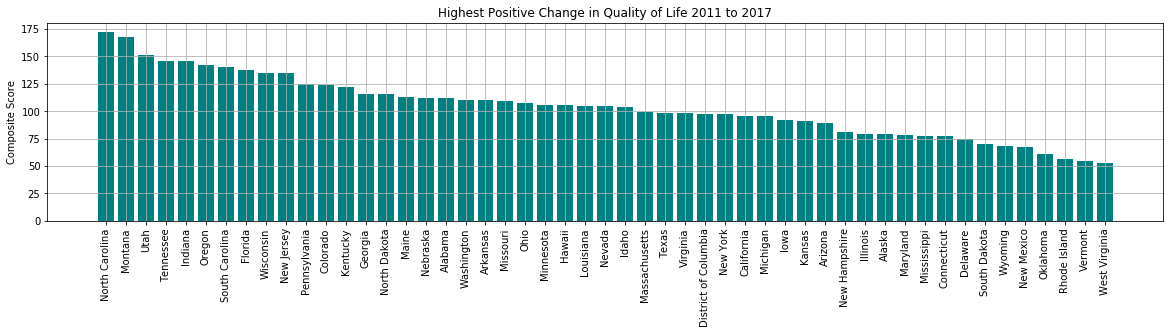

In [116]:

comp_score = finaldf[["State", "Composite Score"]]

# Find percent change
organized_df["Home Value % Change"] = round(((organized_df["Home Value '17"] - organized_df["Home Value '11"]) / organized_df["Home Value '11"])*100,2)
comp_sorted = finaldf.sort_values("Composite Score", ascending=False)

comp_sorted

fig,ax=plt.subplots(figsize=(20,5))
fig.subplots_adjust(bottom=0.33)
plt.bar(comp_sorted["State"], comp_sorted["Composite Score"], color='teal', alpha=1, align="center")
plt.xticks(comp_sorted["State"], rotation='90')
plt.title("Highest Positive Change in Quality of Life 2011 to 2017")
plt.ylabel("Composite Score")
plt.grid()
plt.show

plt.savefig('Output/CompositeScore.png')

In [118]:
finaldf.to_csv("Output/Final_DF.csv")